In [1]:
import pandas as pd
import numpy as np
import talib
from utils import utils
import os
%matplotlib inline

In [2]:
df = pd.read_csv('../data/USDJPY.csv')
df.sample(5)

,Gmt time,Open,High,Low,Close,Volume
77381,17.09.2015 19:00:00.000,120.235,120.390,119.797,119.887,14503.9404
90872,15.11.2017 13:00:00.000,112.765,112.870,112.483,112.653,12790.7998
31780,30.05.2008 18:00:00.000,105.420,105.480,105.340,105.455,8009.7002
3212,07.11.2003 04:00:00.000,110.203,110.257,110.156,110.181,14328.2998
82473,13.07.2016 13:00:00.000,104.526,104.649,104.182,104.301,11562.1299


In [3]:
df = utils.rename_columns_and_format(df)
df = utils.get_all_indicators(df)

df.dropna(inplace=True)
df.head()

,date,open,high,low,close,volume,rsi,ema_12,ema_26,upper_bband,middle_bband,lower_bband,macd,macd_signal,macd_hist,k,d
33,2003-01-08 06:00:00,120.436,120.687,120.331,120.596,11794.4004,69.010347,120.132198,119.921418,120.788292,119.79655,118.804808,0.211636,0.067038,0.144598,45.716382,50.669477
34,2003-01-08 07:00:00,120.572,120.656,120.347,120.407,10637.4004,62.713588,120.174475,119.957387,120.857165,119.83185,118.806535,0.217813,0.097193,0.120620,52.899983,48.448860
35,2003-01-08 08:00:00,120.404,120.632,120.324,120.508,12336.2002,64.573838,120.225787,119.998173,120.936120,119.87120,118.806280,0.228226,0.123399,0.104827,56.862745,51.826370
36,2003-01-08 09:00:00,120.538,120.584,120.235,120.319,13210.7002,58.674600,120.240127,120.021938,120.981654,119.90550,118.829346,0.218708,0.142461,0.076247,36.861357,48.874695
37,2003-01-08 10:00:00,120.316,120.567,120.273,120.496,12268.0996,62.160985,120.279492,120.057054,121.043257,119.95620,118.869143,0.222877,0.158544,0.064333,44.736596,46.153566


## Prueba utilizando indicadores individuales como inputs

In [4]:
WINDOW = 30
P_TRAIN = 0.8
EPOCHS = 100
BATCH_SIZE = 32

### Hacemos un head 500 pq solo es para pruebas

In [5]:
df = df.head(50)

In [6]:
#Elimino metricas viejas antes de escribir las nuevas

metric_files = os.listdir('../metrics')
if metric_files:
    for file in metric_files:
        os.remove('../metrics/' + file)

In [7]:
columns = ['ema_12', 'ema_26', 'upper_bband', 
         'middle_bband', 'lower_bband', 'rsi', 
         'macd', 'macd_signal', 'macd_hist', 'k', 'd']

target_column = df['close'].to_numpy()
for column in columns:
    df_min = df[column]
    x, y = utils.create_windowed_dataset(df_min, target_column, WINDOW)
    x_train, x_test, y_train, y_test = utils.train_test_split(P_TRAIN, x, y)
    
    _, x_input, y_input = x.shape
    model = utils.get_model(x_input, y_input)
    
    x_train = np.expand_dims(x_train, axis=3)
    x_test = np.expand_dims(x_test, axis=3)
    
    history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_test,y_test), 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    verbose=0)
    
    df_history = pd.DataFrame(history.history)
    df_history.to_csv(f'../metrics/{column}.csv', index=False) 

In [8]:
df_metrics = utils.get_input_based_performance()
df_metrics

,loss,val_loss,root_mean_squared_error,val_root_mean_squared_error
macd,2033.872803,19.330481,45.098480,4.396644
macd_signal,1858.076904,92.054405,43.105415,9.594499
d,2881.439941,189.709106,53.679047,13.773493
lower_bband,1769.783203,409.539825,42.068790,20.237091
ema_12,2184.589844,427.298828,46.739597,20.671207
macd_hist,2176.138428,746.940186,46.649097,27.330206
middle_bband,2987.787842,777.317505,54.660660,27.880415
ema_26,1900.453613,871.012085,43.594193,29.512915
upper_bband,3124.507812,911.054626,55.897297,30.183681
k,3931.050293,1165.396484,62.698090,34.137905


## Prueba utilizando todos los indicadores

In [9]:
df_min = df[columns]

x, y = utils.create_windowed_dataset(df_min, df['close'].to_numpy(), WINDOW)
x_train, x_test, y_train, y_test = utils.train_test_split(P_TRAIN, x, y)

_, x_input, y_input = x.shape
model = utils.get_model(x_input, y_input)

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

history = model.fit(x_train, 
                y_train, 
                validation_data=(x_test,y_test), 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS,
                verbose=0)

df_history = pd.DataFrame(history.history)
df_history.to_csv(f'../metrics/all_indicators.csv', index=False)

#evaluacion del modelo
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)

print(f'Perdida en train: {train_score[0]}, RMSE en train: {train_score[1]}')
print(f'Perdida en test: {test_score[0]}, RMSE en test: {test_score[1]}')

Perdida en train: 1111.262451171875, RMSE en train: 33.335601806640625
Perdida en test: 954.9400024414062, RMSE en test: 30.902103424072266


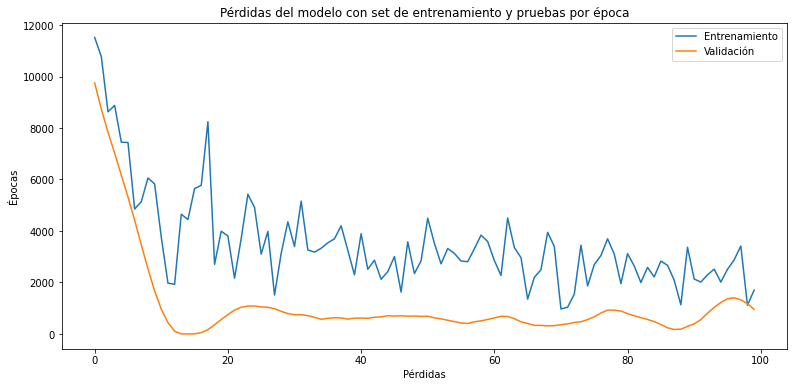

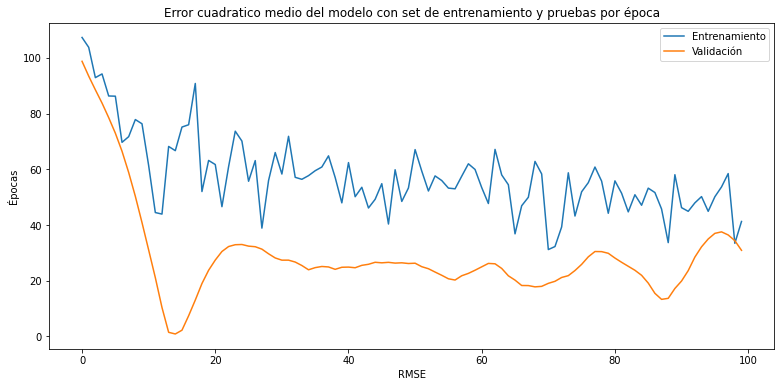

In [10]:
x1 = model.history.history['loss']
x2 = model.history.history['val_loss']
title = "Pérdidas del modelo con set de entrenamiento y pruebas por época"
ylabel = 'Pérdidas'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

x1 = model.history.history['root_mean_squared_error']
x2 = model.history.history['val_root_mean_squared_error']
title = "Error cuadratico medio del modelo con set de entrenamiento y pruebas por época"
ylabel = 'RMSE'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

## Prueba utilizando los indicadores de tipo oscilador 

In [11]:
columns = ['rsi', 'macd', 'macd_signal', 'macd_hist', 'k', 'd']

df_min = df[columns]

x, y = utils.create_windowed_dataset(df_min, df['close'].to_numpy(), WINDOW)
x_train, x_test, y_train, y_test = utils.train_test_split(P_TRAIN, x, y)

_, x_input, y_input = x.shape
model = utils.get_model(x_input, y_input)

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

history = model.fit(x_train, 
                y_train, 
                validation_data=(x_test,y_test), 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS,
                verbose=0)

df_history = pd.DataFrame(history.history)
df_history.to_csv(f'../metrics/oscillator_indicators.csv', index=False)

#evaluacion del modelo
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)

print(f'Perdida en train: {train_score[0]}, RMSE en train: {train_score[1]}')
print(f'Perdida en test: {test_score[0]}, RMSE en test: {test_score[1]}')

Perdida en train: 820.2650146484375, RMSE en train: 28.640268325805664
Perdida en test: 613.7527465820312, RMSE en test: 24.77403450012207


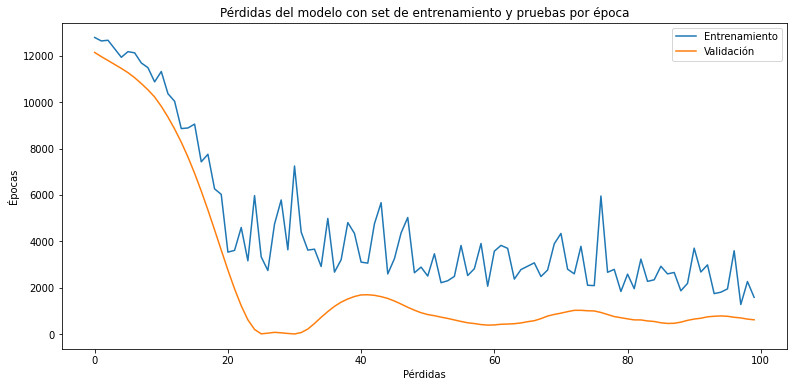

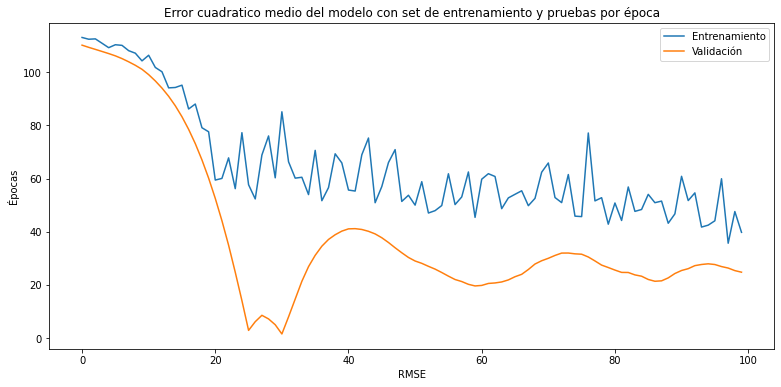

In [12]:
x1 = model.history.history['loss']
x2 = model.history.history['val_loss']
title = "Pérdidas del modelo con set de entrenamiento y pruebas por época"
ylabel = 'Pérdidas'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

x1 = model.history.history['root_mean_squared_error']
x2 = model.history.history['val_root_mean_squared_error']
title = "Error cuadratico medio del modelo con set de entrenamiento y pruebas por época"
ylabel = 'RMSE'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

## Prueba utilizando solo los indicadores de tendencia

In [13]:
columns = ['ema_12', 'ema_26', 'upper_bband', 
         'middle_bband', 'lower_bband']

df_min = df[columns]

x, y = utils.create_windowed_dataset(df_min, df['close'].to_numpy(), WINDOW)
x_train, x_test, y_train, y_test = utils.train_test_split(P_TRAIN, x, y)

_, x_input, y_input = x.shape
model = utils.get_model(x_input, y_input)

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

history = model.fit(x_train, 
                y_train, 
                validation_data=(x_test,y_test), 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS,
                verbose=0)

df_history = pd.DataFrame(history.history)
df_history.to_csv(f'../metrics/trend_indicators.csv', index=False)

#evaluacion del modelo
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)

print(f'Perdida en train: {train_score[0]}, RMSE en train: {train_score[1]}')
print(f'Perdida en test: {test_score[0]}, RMSE en test: {test_score[1]}')

Perdida en train: 885.1820678710938, RMSE en train: 29.752010345458984
Perdida en test: 782.9324951171875, RMSE en test: 27.98093032836914


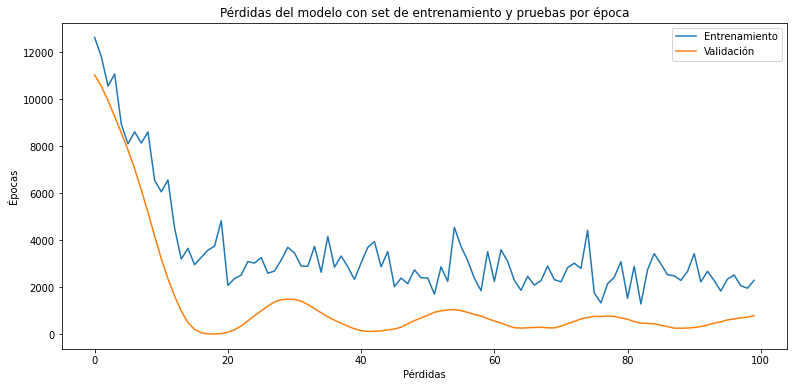

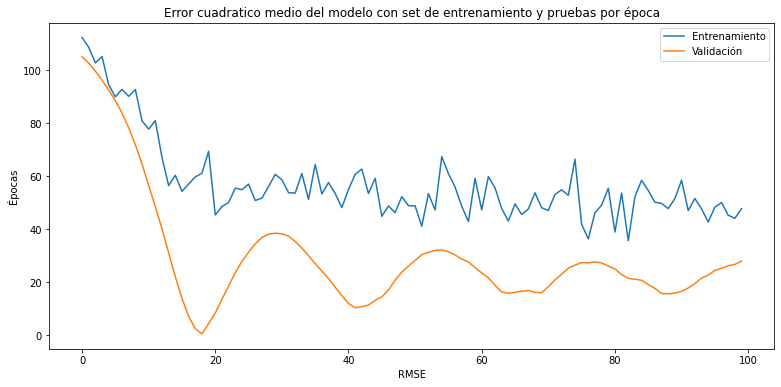

In [14]:
x1 = model.history.history['loss']
x2 = model.history.history['val_loss']
title = "Pérdidas del modelo con set de entrenamiento y pruebas por época"
ylabel = 'Pérdidas'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

x1 = model.history.history['root_mean_squared_error']
x2 = model.history.history['val_root_mean_squared_error']
title = "Error cuadratico medio del modelo con set de entrenamiento y pruebas por época"
ylabel = 'RMSE'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

In [15]:
df_metrics = utils.get_input_based_performance()
df_metrics

,loss,val_loss,root_mean_squared_error,val_root_mean_squared_error
macd,2033.872803,19.330481,45.098480,4.396644
macd_signal,1858.076904,92.054405,43.105415,9.594499
d,2881.439941,189.709106,53.679047,13.773493
lower_bband,1769.783203,409.539825,42.068790,20.237091
ema_12,2184.589844,427.298828,46.739597,20.671207
oscillator_indicators,1581.991211,613.752747,39.774254,24.774035
macd_hist,2176.138428,746.940186,46.649097,27.330206
middle_bband,2987.787842,777.317505,54.660660,27.880415
trend_indicators,2284.708008,782.932495,47.798618,27.980930
ema_26,1900.453613,871.012085,43.594193,29.512915


In [16]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

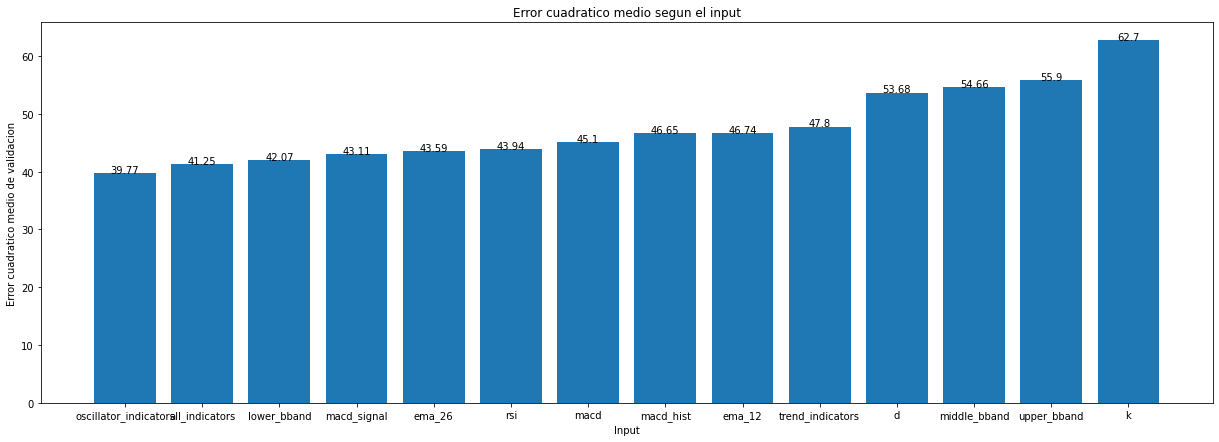

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# creating the bar plot
df_metrics.sort_values(by=['root_mean_squared_error'], inplace=True)

fig = plt.figure(figsize =(21, 7))

x, y = df_metrics.index, df_metrics['root_mean_squared_error']

plt.bar(x, y)

addlabels(x, round(y, 2))

plt.xlabel("Input")
plt.ylabel("Error cuadratico medio de validacion")
plt.title("Error cuadratico medio segun el input")
plt.show()

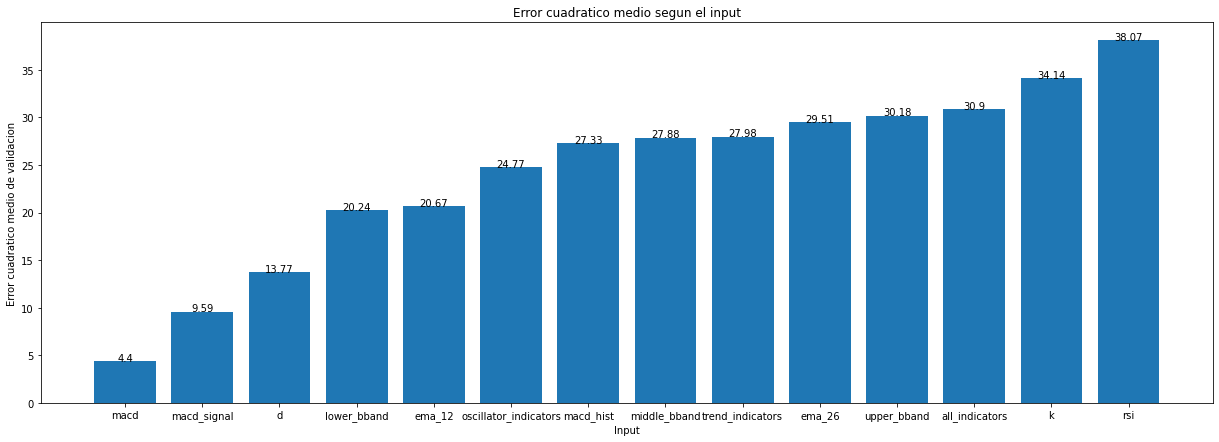

In [23]:
# creating the bar plot
# creating the bar plot
df_metrics.sort_values(by=['val_root_mean_squared_error'], inplace=True)

fig = plt.figure(figsize =(21, 7))

x, y = df_metrics.index, df_metrics['val_root_mean_squared_error']

plt.bar(x, y)

addlabels(x, round(y, 2))

plt.xlabel("Input")
plt.ylabel("Error cuadratico medio de validacion")
plt.title("Error cuadratico medio segun el input")
plt.show()